In [102]:
## Load in all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import kurtosis

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,roc_curve,auc, make_scorer,mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA, NMF, FastICA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
import warnings
import pickle
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

#font for plots
font = {'fontname':'Arial'}

In [103]:
# Load in the data
# Note the raw will be for if individuals wish to put in a MAD filter on the data
train_data = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_individual/human_train_vst_normalised_data.txt", sep = "\t").T
test_data = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_individual/human_test_vst_normalised_data.txt", sep = "\t").T
val_data = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_individual/human_val_vst_normalised_data.txt", sep = "\t").T
train_labels = pd.read_csv("/home/workspace/jogrady/ML4TB/data/human/train_labels.txt", sep = "\t").T.to_numpy() 
test_labels = pd.read_csv("/home/workspace/jogrady/ML4TB/data/human/test_labels.txt", sep = "\t").T.to_numpy() 
val_labels = pd.read_csv("/home/workspace/jogrady/ML4TB/data/human/val_labels.txt", sep = "\t").T.to_numpy()

In [104]:
# Read in the normalised data for pairwise comparison
train_data_test_normalised = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_combined/human_train_vst_normalised_human_test.txt", sep = "\t").T
train_data_val_normalised = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_combined/human_train_vst_normalised_human_val.txt", sep = "\t").T
test_data_train_normalised = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_combined/human_test_vst_normalised_human_train.txt", sep = "\t").T
test_data_val_normalised = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_combined/human_test_vst_normalised_human_val.txt", sep = "\t").T
val_data_train_normalised = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_combined/human_val_vst_normalised_human_train.txt", sep = "\t").T
val_data_test_normalised = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_combined/human_val_vst_normalised_human_test.txt", sep = "\t").T

In [105]:
train_data = train_data.loc[:,~train_data.columns.duplicated()].copy()
test_data = test_data.loc[:,~test_data.columns.duplicated()].copy()
val_data = val_data.loc[:,~val_data.columns.duplicated()].copy()
# And for pairwise comparison
train_data_test_normalised = train_data_test_normalised.loc[:,~train_data_test_normalised.columns.duplicated()].copy()
train_data_val_normalised = train_data_val_normalised.loc[:,~train_data_val_normalised.columns.duplicated()].copy()
test_data_train_normalised = test_data_train_normalised.loc[:,~test_data_train_normalised.columns.duplicated()].copy()
test_data_val_normalised = test_data_val_normalised.loc[:,~test_data_val_normalised.columns.duplicated()].copy()
val_data_train_normalised = val_data_train_normalised.loc[:,~val_data_train_normalised.columns.duplicated()].copy()
val_data_test_normalised = val_data_test_normalised.loc[:,~val_data_test_normalised.columns.duplicated()].copy()

# 1. Training Set
## Gene based

We need to Train the models on the trianing set, evlauate via k fold cross validation internally. THen we need to do the same in the test and val and then do a cross comparison on eachother.

In [106]:
train_labels = train_labels.astype(int)

In [107]:
# Calcualte variances for VST normalised genes
variances = train_data.var(axis=0)
variances = variances
# take top 20% and filter
threshold = variances.quantile(.90) 
genes = variances > threshold
genes_train= genes.loc[genes==True].index
train_data = train_data.filter(items = genes_train, axis=1)

# Reapply to test
#test_data = test_data.filter(items = genes, axis = 1)

In [72]:
print(train_data.shape, test_data.shape, val_data.shape)

(130, 5664) (61, 56634) (60, 56634)


In [8]:
KF =  KFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
# Make a pipeline for logistic regression and set the paramaters
log_pipe = Pipeline(steps=[
('scaler', StandardScaler()), # see comment above (in markdown)
('classifier', LogisticRegression(max_iter=10000, solver='saga', tol=0.0001, random_state=42))]) # classifier

precision_scorer = make_scorer(precision_score, zero_division=1)  # had to modify zero_division as it was giving problems
f1_scorer = make_scorer(f1_score)
accuracy_scorer = make_scorer(accuracy_score)
recall_scorer = make_scorer(recall_score)

# Define scoring dictionary for GridSearchCV
scoring = {
    'accuracy': accuracy_scorer,
    'f1': f1_scorer,
    'precision': precision_scorer,
    'recall': recall_scorer
}

# Create a parameter grid - we will search through all these combinations
param_grid = {
    'classifier__penalty': ["elasticnet"],
    'classifier__l1_ratio': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
}
 
# Create GridSearchCV object
grid_search = GridSearchCV(log_pipe, param_grid, cv=KF, verbose=1, n_jobs=60, scoring=scoring, refit="accuracy")

In [10]:
grid_search.fit(train_data, train_labels.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=60,
             param_grid={'classifier__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9],
                         'classifier__penalty': ['elasticnet']},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': make_scorer(recall_score)},
             verbose=1)

In [11]:
# Post-processing: Count non-zero coefficients
# unfortunatley, grid search CV doesn't return coefficients for all models so we will have to re run and fit with all the paramaters again
non_zero_counts = []
for params, mean_score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_accuracy']):
    # Manually fit the pipeline with the parameters
    model = log_pipe.set_params(**params)
    model.fit(train_data, train_labels.ravel())  # Re-fit the model on the entire dataset
    non_zero_count = np.sum(model.named_steps['classifier'].coef_ != 0)
    non_zero_counts.append((params, mean_score, non_zero_count))

non_zero_counts_df = pd.DataFrame(non_zero_counts)

non_zero_counts_df

,0,1,2
0,"{'classifier__l1_ratio': 0.1, 'classifier__pen...",0.815385,1836
1,"{'classifier__l1_ratio': 0.2, 'classifier__pen...",0.830769,956
2,"{'classifier__l1_ratio': 0.3, 'classifier__pen...",0.830769,637
3,"{'classifier__l1_ratio': 0.4, 'classifier__pen...",0.815385,500
4,"{'classifier__l1_ratio': 0.5, 'classifier__pen...",0.807692,381
5,"{'classifier__l1_ratio': 0.6, 'classifier__pen...",0.807692,318
6,"{'classifier__l1_ratio': 0.7, 'classifier__pen...",0.815385,273
7,"{'classifier__l1_ratio': 0.8, 'classifier__pen...",0.807692,236
8,"{'classifier__l1_ratio': 0.9, 'classifier__pen...",0.815385,209


In [12]:
# Look at best paramaters and accuracy and save results to a data frame
non_zero_counts_df = non_zero_counts_df.rename(columns={0: "Paramaters", 1: "Average Accuracy", 2: "Non-zero coefficeints"})
print("Best Parameters:", grid_search.best_params_)
print(f"Best CV average accuracy: {grid_search.best_score_:.3f}")
results_genes = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_accuracy"], columns = ["Average Accuracy"]),
           pd.DataFrame(grid_search.cv_results_["std_test_accuracy"], columns=["SD accuracy"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_precision"], columns = ["Average precision"]),
           pd.DataFrame(grid_search.cv_results_["std_test_precision"], columns=["SD precision"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_recall"], columns=["Average recall"]),
           pd.DataFrame(grid_search.cv_results_["std_test_recall"], columns=["SD recall"])],axis=1)

results_genes = pd.concat([results_genes, non_zero_counts_df.loc[:,["Non-zero coefficeints"]]], axis=1)
results_genes.sort_values(by='Average Accuracy', inplace=True)
results_models = pd.DataFrame(grid_search.cv_results_)
results_models.sort_values(by='rank_test_accuracy', inplace=True)
results_genes.to_csv("/home/workspace/jogrady/ML4TB/results/Logistic_regression/CV_results/Human_train_gene_CV_results.txt")
results_genes

Best Parameters: {'classifier__l1_ratio': 0.2, 'classifier__penalty': 'elasticnet'}
Best CV average accuracy: 0.831


,classifier__l1_ratio,classifier__penalty,Average Accuracy,SD accuracy,Average precision,SD precision,Average recall,SD recall,Non-zero coefficeints
4,0.5,elasticnet,0.807692,0.068802,0.814211,0.125492,0.847941,0.095202,381
5,0.6,elasticnet,0.807692,0.068802,0.814211,0.125492,0.847941,0.095202,318
7,0.8,elasticnet,0.807692,0.054393,0.814286,0.116815,0.847941,0.095202,236
0,0.1,elasticnet,0.815385,0.051025,0.838240,0.084159,0.818271,0.097606,1836
3,0.4,elasticnet,0.815385,0.066172,0.816775,0.125987,0.862227,0.077853,500
6,0.7,elasticnet,0.815385,0.078446,0.825322,0.138334,0.847941,0.095202,273
8,0.9,elasticnet,0.815385,0.051025,0.816850,0.117345,0.862227,0.077853,209
1,0.2,elasticnet,0.830769,0.030769,0.843834,0.083568,0.846842,0.052618,956
2,0.3,elasticnet,0.830769,0.039223,0.835237,0.096083,0.862227,0.077853,637


In [13]:
params = {'classifier__l1_ratio': 0.7, 'classifier__penalty': 'elasticnet'}
model = log_pipe.set_params(**params)
model.fit(train_data, train_labels.ravel())  # Re-fit the model on the entire dataset
# Save model in case we ever need it again e.g. for external data

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(l1_ratio=0.7, max_iter=10000,
                                    penalty='elasticnet', random_state=42,
                                    solver='saga'))])

In [14]:
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Human_train_gene_LR_l10.7_search.pkl', 'wb') as f:
    pickle.dump(model, f)

## PCA

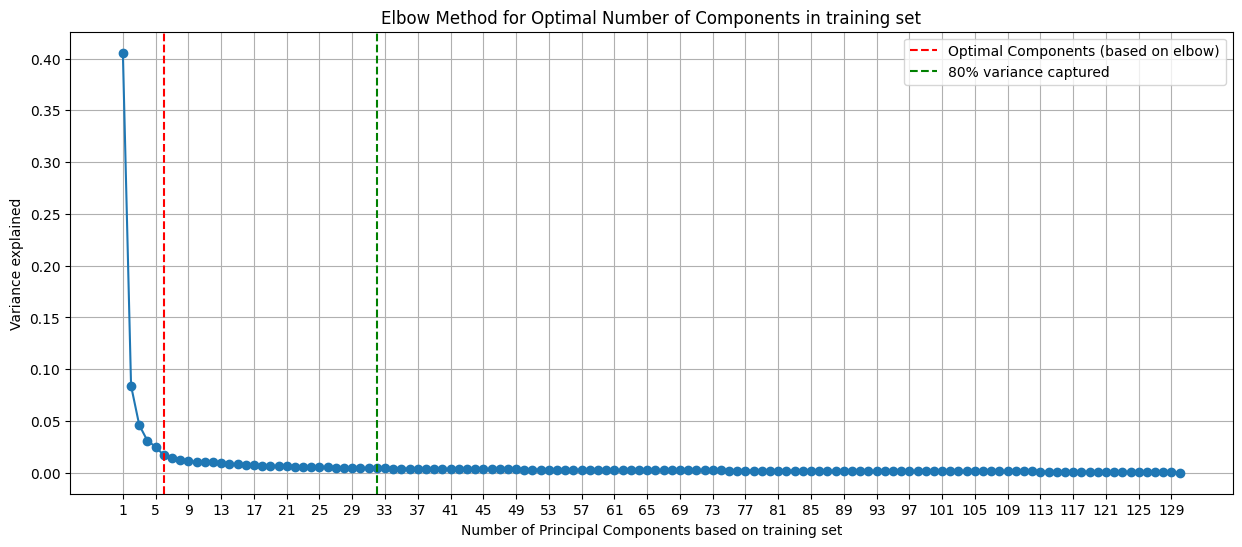

Variance captured by 32 PCs:0.80


In [15]:
 # Do not need to scale for PCA - not recommended in VST
pca = PCA(random_state=88, n_components=130)
pca.fit(train_data)
explained_variance = pca.explained_variance_ratio_
# Plotting the elbow curve
plt.figure(figsize=(15, 6))
plt.plot(range(1, 130 + 1), explained_variance, marker='o')
plt.xlabel('Number of Principal Components based on training set')
plt.ylabel('Variance explained')
plt.title('Elbow Method for Optimal Number of Components in training set')
plt.grid()
plt.xticks(range(1, 130 + 1,4))
plt.axvline(x= 6, color='r', linestyle='--', label='Optimal Components (based on elbow)')
plt.axvline(x=32, color='g', linestyle='--', label='80% variance captured')
plt.legend()
plt.show()
print(f'Variance captured by 32 PCs:{pca.explained_variance_ratio_[:32].sum():.2f}')

In [16]:
# Set up the pipeline
PCA_Pipeline = Pipeline(steps=[('pca', PCA(random_state=42)),
('classifier', LogisticRegression(max_iter=10000, penalty="none", solver='saga', tol=0.0001, random_state=42))])

# Set up a grid for each PC
pca_param_grid = {'pca__n_components': list(range(1, 33))}

# Apply
LR_pca_search_model = GridSearchCV(PCA_Pipeline, pca_param_grid, cv=KF, scoring=scoring, refit="accuracy")

# Fit
LR_pca_search_model.fit(train_data, train_labels.ravel())

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='none',
                                                           random_state=42,
                                                           solver='saga'))]),
             param_grid={'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14, 15, 16, 17, 18,
                                               19, 20, 21, 22, 23, 24, 25, 26,
                                               27, 28, 29, 30, ...]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': make_scorer(recall_score)})

In [17]:
# Look at best paramaters and accuracy and save results to a data frame
print(f"Best Paramater:", LR_pca_search_model.best_params_)
print(f"Best Score: {LR_pca_search_model.best_score_:.2f}")
results_pca = pd.concat([pd.DataFrame(LR_pca_search_model.cv_results_["params"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["mean_test_accuracy"], columns = ["CV Accuracy"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["std_test_accuracy"], columns=["SD accuracy"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["mean_test_precision"], columns = ["CV precision"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["std_test_precision"], columns=["SD precision"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["mean_test_recall"], columns=["CV recall"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["std_test_recall"], columns=["SD recall"])],axis=1)
results_pca.sort_values(by='CV Accuracy', inplace=True)
print(results_pca.tail(40))


Best Paramater: {'pca__n_components': 32}
Best Score: 0.81
    pca__n_components  CV Accuracy  SD accuracy  CV precision  SD precision  \
1                   2     0.484615     0.138888      0.563782      0.141841   
0                   1     0.538462     0.087706      0.556493      0.100735   
3                   4     0.746154     0.067060      0.813333      0.163095   
2                   3     0.769231     0.072976      0.800513      0.151106   
22                 23     0.769231     0.064358      0.791569      0.115343   
21                 22     0.769231     0.064358      0.781569      0.116341   
16                 17     0.769231     0.068802      0.782521      0.117487   
27                 28     0.776923     0.074580      0.787677      0.102040   
9                  10     0.776923     0.074580      0.810962      0.149600   
12                 13     0.776923     0.066172      0.817402      0.153905   
23                 24     0.776923     0.056527      0.790140      0.103

In [18]:
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Human_train_Logistic_regression_PCA_search.pkl', 'wb') as f:
    pickle.dump(LR_pca_search_model, f)
results_pca.to_csv(path_or_buf="/home/workspace/jogrady/ML4TB/results/Logistic_regression/CV_results/Human_train_PCA_CV_results.txt", sep = "\t")

## ICA

In [19]:
# ICA
from sklearn.decomposition import FastICA
ICA_transformer = FastICA(n_components=32, # from PCA - 80% of variance
        random_state=42,
        max_iter=1000, tol=0.0001,
        whiten='unit-variance')

df_train_ica = ICA_transformer.fit_transform(train_data)
kurtosis_scores = [kurtosis(df_train_ica[:, i]) for i in range(df_train_ica.shape[1])]
n_components = np.argmax(kurtosis_scores) + 1
# Number of non-normal components in training data = 14 - however we will use the same as above for PCA
n_components

3

In [20]:
# Set up the pipeline
ICA_Pipeline = Pipeline(steps=[('ica', FastICA( 
        random_state=42,
        max_iter=5000, tol=0.0001,
        whiten='unit-variance')),
('classifier', LogisticRegression(max_iter=10000, penalty="none", solver='saga', tol=0.0001, random_state=42))])

# Set up grid of components - 80% from PCA above
ica_param_grid = {'ica__n_components': list(range(1, 33))}


# Apply
LR_ica_search_model = GridSearchCV(ICA_Pipeline, ica_param_grid, cv=KF, scoring=scoring, refit="accuracy")


# Fit
LR_ica_search_model.fit(train_data, train_labels.ravel())

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('ica',
                                        FastICA(max_iter=5000,
                                                random_state=42)),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='none',
                                                           random_state=42,
                                                           solver='saga'))]),
             param_grid={'ica__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14, 15, 16, 17, 18,
                                               19, 20, 21, 22, 23, 24, 25, 26,
                                               27, 28, 29, 30, ...]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': make_scorer(recall_score)})

In [21]:
# Look at best paramaters and accuracy and save results to a data frame
print("Best Parameters:", LR_ica_search_model.best_params_)
print(f"Best Score: {LR_ica_search_model.best_score_:.2f}")
results_ica = pd.concat([pd.DataFrame(LR_ica_search_model.cv_results_["params"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["mean_test_accuracy"], columns = ["CV Accuracy"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["std_test_accuracy"], columns=["SD accuracy"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["mean_test_precision"], columns = ["CV precision"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["std_test_precision"], columns=["SD precision"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["mean_test_recall"], columns=["CV recall"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["std_test_recall"], columns=["SD recall"])],axis=1)
results_ica.sort_values(by='CV Accuracy', inplace=True)

Best Parameters: {'ica__n_components': 8}
Best Score: 0.79


In [22]:
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Human_train_Logistic_regression_ICA_search.pkl', 'wb') as f:
    pickle.dump(LR_ica_search_model, f)
results_ica.to_csv(path_or_buf="/home/workspace/jogrady/ML4TB/results/Logistic_regression/CV_results/Human_train_ICA_CV_results.txt", sep = "\t")
results_ica

,ica__n_components,CV Accuracy,SD accuracy,CV precision,SD precision,CV recall,SD recall
1,2,0.523077,0.067060,0.573212,0.118396,0.819173,0.152561
0,1,0.561538,0.104909,0.561538,0.104909,1.000000,0.000000
19,20,0.738462,0.074580,0.764811,0.137258,0.784718,0.091231
29,30,0.746154,0.086346,0.764939,0.129710,0.776100,0.112539
18,19,0.746154,0.062493,0.771429,0.126092,0.784718,0.091231
17,18,0.746154,0.062493,0.771429,0.126092,0.784718,0.091231
2,3,0.753846,0.086346,0.771335,0.166620,0.829685,0.077790
28,29,0.753846,0.089707,0.768272,0.129067,0.791485,0.125567
21,22,0.753846,0.086346,0.777451,0.139679,0.793459,0.117846
20,21,0.753846,0.092947,0.776200,0.139295,0.791485,0.125567


## NMF

In [23]:
NMF_Pipeline = Pipeline(steps=[('nmf', NMF(
    init="random", solver='cd', 
    beta_loss='frobenius', tol=0.0001, 
    max_iter=10000, random_state=42, verbose=0)),
('classifier', LogisticRegression(max_iter=10000, penalty=None, solver='saga', tol=0.0001, random_state=42))])

nmf_param_grid = {'nmf__n_components': list(range(1, 33))}

LR_nmf_search_model = GridSearchCV(NMF_Pipeline, nmf_param_grid, cv=KF, n_jobs= 50, scoring=scoring, refit="accuracy")

LR_nmf_search_model.fit(train_data, train_labels.ravel())

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('nmf',
                                        NMF(init='random', max_iter=10000,
                                            random_state=42)),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000,
                                                           penalty=None,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=50,
             param_grid={'nmf__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14, 15, 16, 17, 18,
                                               19, 20, 21, 22, 23, 24, 25, 26,
                                               27, 28, 29, 30, ...]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': make_scorer(recall_score)})

In [24]:
# Look at best paramaters and accuracy and save results to a data frame
print("Best Parameters:", LR_nmf_search_model.best_params_)
print(f"Best Score: {LR_nmf_search_model.best_score_:.2f}")
results_nmf = pd.concat([pd.DataFrame(LR_nmf_search_model.cv_results_["params"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["mean_test_accuracy"], columns = ["CV Accuracy"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["std_test_accuracy"], columns=["SD accuracy"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["mean_test_precision"], columns = ["CV precision"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["std_test_precision"], columns=["SD precision"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["mean_test_recall"], columns=["CV recall"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["std_test_recall"], columns=["SD recall"])],axis=1)
results_nmf.sort_values(by='CV Accuracy', inplace=True)
results_nmf.to_csv(path_or_buf="/home/workspace/jogrady/ML4TB/results/Logistic_regression/CV_results/Human_train_NMF_CV_results.txt", sep = "\t")

Best Parameters: {'nmf__n_components': 5}
Best Score: 0.80


In [25]:
results_ica

,ica__n_components,CV Accuracy,SD accuracy,CV precision,SD precision,CV recall,SD recall
1,2,0.523077,0.067060,0.573212,0.118396,0.819173,0.152561
0,1,0.561538,0.104909,0.561538,0.104909,1.000000,0.000000
19,20,0.738462,0.074580,0.764811,0.137258,0.784718,0.091231
29,30,0.746154,0.086346,0.764939,0.129710,0.776100,0.112539
18,19,0.746154,0.062493,0.771429,0.126092,0.784718,0.091231
17,18,0.746154,0.062493,0.771429,0.126092,0.784718,0.091231
2,3,0.753846,0.086346,0.771335,0.166620,0.829685,0.077790
28,29,0.753846,0.089707,0.768272,0.129067,0.791485,0.125567
21,22,0.753846,0.086346,0.777451,0.139679,0.793459,0.117846
20,21,0.753846,0.092947,0.776200,0.139295,0.791485,0.125567


In [26]:
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Human_train_Logistic_regression_NMF_search.pkl', 'wb') as f:
    pickle.dump(LR_nmf_search_model, f)

# 2. Testing data

In [108]:
# remember, data already loaded in
test_labels = test_labels.astype(int)
# Calcualte variances for VST normalised genes
variances = test_data.var(axis=0)
variances = variances
# take top 20% and filter
threshold = variances.quantile(.90) 
genes = variances > threshold
genes_test= genes.loc[genes==True].index
test_data = test_data.filter(items = genes_test, axis=1)

In [109]:
print(train_data.shape, test_data.shape, val_data.shape)
KF =  KFold(n_splits=5, shuffle=True, random_state=42)

(130, 5664) (61, 5664) (60, 56634)


In [29]:
# Make a pipeline for logistic regression and set the paramaters
log_pipe = Pipeline(steps=[
('scaler', StandardScaler()), # see comment above (in markdown)
('classifier', LogisticRegression(max_iter=10000, solver='saga', tol=0.0001, random_state=42))]) # classifier

precision_scorer = make_scorer(precision_score, zero_division=1)  # had to modify zero_division as it was giving problems
f1_scorer = make_scorer(f1_score)
accuracy_scorer = make_scorer(accuracy_score)
recall_scorer = make_scorer(recall_score)

# Define scoring dictionary for GridSearchCV
scoring = {
    'accuracy': accuracy_scorer,
    'f1': f1_scorer,
    'precision': precision_scorer,
    'recall': recall_scorer
}

# Create a parameter grid - we will search through all these combinations
param_grid = {
    'classifier__penalty': ["elasticnet"],
    'classifier__l1_ratio': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
}
 
# Create GridSearchCV object
grid_search = GridSearchCV(log_pipe, param_grid, cv=KF, verbose=1, n_jobs=60, scoring=scoring, refit="accuracy")
grid_search.fit(test_data, test_labels.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=60,
             param_grid={'classifier__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9],
                         'classifier__penalty': ['elasticnet']},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': make_scorer(recall_score)},
             verbose=1)

In [30]:
# Post-processing: Count non-zero coefficients
# unfortunatley, grid search CV doesn't return coefficients for all models so we will have to re run and fit with all the paramaters again
non_zero_counts = []
for params, mean_score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_accuracy']):
    # Manually fit the pipeline with the parameters
    model = log_pipe.set_params(**params)
    model.fit(test_data, test_labels.ravel())  # Re-fit the model on the entire dataset
    non_zero_count = np.sum(model.named_steps['classifier'].coef_ != 0)
    non_zero_counts.append((params, mean_score, non_zero_count))

non_zero_counts_df = pd.DataFrame(non_zero_counts)

non_zero_counts_df

,0,1,2
0,"{'classifier__l1_ratio': 0.1, 'classifier__pen...",0.820513,1366
1,"{'classifier__l1_ratio': 0.2, 'classifier__pen...",0.837179,699
2,"{'classifier__l1_ratio': 0.3, 'classifier__pen...",0.820513,447
3,"{'classifier__l1_ratio': 0.4, 'classifier__pen...",0.820513,321
4,"{'classifier__l1_ratio': 0.5, 'classifier__pen...",0.820513,253
5,"{'classifier__l1_ratio': 0.6, 'classifier__pen...",0.820513,204
6,"{'classifier__l1_ratio': 0.7, 'classifier__pen...",0.837179,171
7,"{'classifier__l1_ratio': 0.8, 'classifier__pen...",0.837179,149
8,"{'classifier__l1_ratio': 0.9, 'classifier__pen...",0.837179,131


In [31]:
# Look at best paramaters and accuracy and save results to a data frame
non_zero_counts_df = non_zero_counts_df.rename(columns={0: "Paramaters", 1: "Average Accuracy", 2: "Non-zero coefficeints"})
print("Best Parameters:", grid_search.best_params_)
print(f"Best CV average accuracy: {grid_search.best_score_:.3f}")
results_genes = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_accuracy"], columns = ["Average Accuracy"]),
           pd.DataFrame(grid_search.cv_results_["std_test_accuracy"], columns=["SD accuracy"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_precision"], columns = ["Average precision"]),
           pd.DataFrame(grid_search.cv_results_["std_test_precision"], columns=["SD precision"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_recall"], columns=["Average recall"]),
           pd.DataFrame(grid_search.cv_results_["std_test_recall"], columns=["SD recall"])],axis=1)

results_genes = pd.concat([results_genes, non_zero_counts_df.loc[:,["Non-zero coefficeints"]]], axis=1)
results_genes.sort_values(by='Average Accuracy', inplace=True)
results_models = pd.DataFrame(grid_search.cv_results_)
results_models.sort_values(by='rank_test_accuracy', inplace=True)
results_genes.to_csv("/home/workspace/jogrady/ML4TB/results/Logistic_regression/CV_results/Human_test_gene_CV_results.txt")
results_genes

Best Parameters: {'classifier__l1_ratio': 0.2, 'classifier__penalty': 'elasticnet'}
Best CV average accuracy: 0.837


,classifier__l1_ratio,classifier__penalty,Average Accuracy,SD accuracy,Average precision,SD precision,Average recall,SD recall,Non-zero coefficeints
0,0.1,elasticnet,0.820513,0.094820,0.891667,0.148137,0.797778,0.146127,1366
2,0.3,elasticnet,0.820513,0.058611,0.876190,0.152381,0.831111,0.167833,447
3,0.4,elasticnet,0.820513,0.058611,0.876190,0.152381,0.831111,0.167833,321
4,0.5,elasticnet,0.820513,0.058611,0.876190,0.152381,0.831111,0.167833,253
5,0.6,elasticnet,0.820513,0.058611,0.876190,0.152381,0.831111,0.167833,204
1,0.2,elasticnet,0.837179,0.070524,0.900000,0.133333,0.831111,0.167833,699
6,0.7,elasticnet,0.837179,0.046861,0.892857,0.131708,0.831111,0.167833,171
7,0.8,elasticnet,0.837179,0.046861,0.892857,0.131708,0.831111,0.167833,149
8,0.9,elasticnet,0.837179,0.046861,0.892857,0.131708,0.831111,0.167833,131


In [32]:
params = {'classifier__l1_ratio': 0.9, 'classifier__penalty': 'elasticnet'}
model = log_pipe.set_params(**params)
model.fit(test_data, test_labels.ravel())  # Re-fit the model on the entire dataset
# Save model in case we ever need it again e.g. for external data
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Human_test_gene_LR_l10.9_search.pkl', 'wb') as f:
    pickle.dump(model, f)

## PCA

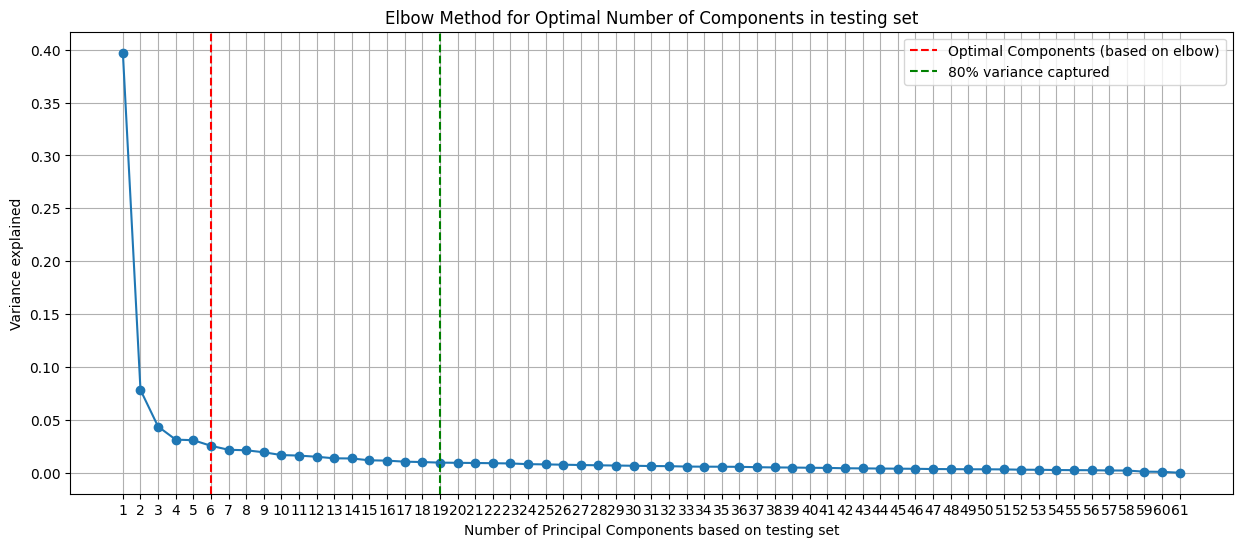

Variance captured by 19 PCs:0.80


In [33]:
pca = PCA(random_state=88, n_components=61)
pca.fit(test_data)
explained_variance = pca.explained_variance_ratio_
# Plotting the elbow curve
plt.figure(figsize=(15, 6))
plt.plot(range(1, 61 + 1), explained_variance, marker='o')
plt.xlabel('Number of Principal Components based on testing set')
plt.ylabel('Variance explained')
plt.title('Elbow Method for Optimal Number of Components in testing set')
plt.grid()
plt.xticks(range(1, 61 + 1,1))
plt.axvline(x= 6, color='r', linestyle='--', label='Optimal Components (based on elbow)')
plt.axvline(x=19, color='g', linestyle='--', label='80% variance captured')
plt.legend()
plt.show()
print(f'Variance captured by 19 PCs:{pca.explained_variance_ratio_[:19].sum():.2f}')


In [34]:
# Set up the pipeline
PCA_Pipeline = Pipeline(steps=[('pca', PCA(random_state=42)),
('classifier', LogisticRegression(max_iter=10000, penalty="none", solver='saga', tol=0.0001, random_state=42))])

# Set up a grid for each PC
pca_param_grid = {'pca__n_components': list(range(1, 20))}

# Apply
LR_pca_search_model = GridSearchCV(PCA_Pipeline, pca_param_grid, cv=KF, scoring=scoring, refit="accuracy")

# Fit
LR_pca_search_model.fit(test_data, test_labels.ravel())
# Look at best paramaters and accuracy and save results to a data frame
print(f"Best Paramater:", LR_pca_search_model.best_params_)
print(f"Best Score: {LR_pca_search_model.best_score_:.2f}")
results_pca = pd.concat([pd.DataFrame(LR_pca_search_model.cv_results_["params"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["mean_test_accuracy"], columns = ["CV Accuracy"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["std_test_accuracy"], columns=["SD accuracy"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["mean_test_precision"], columns = ["CV precision"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["std_test_precision"], columns=["SD precision"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["mean_test_recall"], columns=["CV recall"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["std_test_recall"], columns=["SD recall"])],axis=1)
results_pca.sort_values(by='CV Accuracy', inplace=True)

Best Paramater: {'pca__n_components': 7}
Best Score: 0.79


In [35]:
results_pca

,pca__n_components,CV Accuracy,SD accuracy,CV precision,SD precision,CV recall,SD recall
0,1,0.424359,0.112383,0.508052,0.165928,0.635556,0.299662
1,2,0.523077,0.070057,0.682540,0.263320,0.540000,0.201672
2,3,0.689744,0.074491,0.798095,0.125541,0.595556,0.150325
3,4,0.689744,0.052642,0.828333,0.166966,0.577778,0.139841
12,13,0.706410,0.076752,0.730556,0.124722,0.775556,0.170750
16,17,0.721795,0.063536,0.740455,0.141906,0.808889,0.193525
11,12,0.721795,0.063536,0.763889,0.163865,0.775556,0.170750
8,9,0.721795,0.063536,0.747778,0.164630,0.775556,0.170750
9,10,0.721795,0.063536,0.747778,0.164630,0.775556,0.170750
17,18,0.737179,0.098142,0.762857,0.134498,0.848889,0.131393


In [36]:
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Human_test_Logistic_regression_PCA_search.pkl', 'wb') as f:
    pickle.dump(LR_pca_search_model, f)
results_pca.to_csv(path_or_buf="/home/workspace/jogrady/ML4TB/results/Logistic_regression/CV_results/Human_test_PCA_CV_results.txt", sep = "\t")

## ICA

In [37]:
from sklearn.decomposition import FastICA
ICA_transformer = FastICA(n_components=19, # from PCA - 80% of variance
        random_state=42,
        max_iter=1000, tol=0.0001,
        whiten='unit-variance')
df_test_ica = ICA_transformer.fit_transform(test_data)
kurtosis_scores = [kurtosis(df_test_ica[:, i]) for i in range(df_test_ica.shape[1])]
n_components = np.argmax(kurtosis_scores) + 1

In [38]:
ICA_Pipeline = Pipeline(steps=[('ica', FastICA( 
        random_state=42,
        max_iter=5000, tol=0.0001,
        whiten='unit-variance')),
('classifier', LogisticRegression(max_iter=10000, penalty="none", solver='saga', tol=0.0001, random_state=42))])

# Set up grid of components - 80% from PCA above
ica_param_grid = {'ica__n_components': list(range(1, 20))}


# Apply
LR_ica_search_model = GridSearchCV(ICA_Pipeline, ica_param_grid, cv=KF, scoring=scoring, refit="accuracy")


# Fit
LR_ica_search_model.fit(test_data, test_labels.ravel())
# Look at best paramaters and accuracy and save results to a data frame
print("Best Parameters:", LR_ica_search_model.best_params_)
print(f"Best Score: {LR_ica_search_model.best_score_:.2f}")
results_ica = pd.concat([pd.DataFrame(LR_ica_search_model.cv_results_["params"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["mean_test_accuracy"], columns = ["CV Accuracy"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["std_test_accuracy"], columns=["SD accuracy"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["mean_test_precision"], columns = ["CV precision"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["std_test_precision"], columns=["SD precision"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["mean_test_recall"], columns=["CV recall"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["std_test_recall"], columns=["SD recall"])],axis=1)
results_ica.sort_values(by='CV Accuracy', inplace=True)
results_ica

Best Parameters: {'ica__n_components': 7}
Best Score: 0.77


,ica__n_components,CV Accuracy,SD accuracy,CV precision,SD precision,CV recall,SD recall
0,1,0.425641,0.055677,0.510952,0.099221,0.737778,0.250392
1,2,0.489744,0.128244,0.617172,0.214855,0.620000,0.244687
2,3,0.606410,0.081347,0.675000,0.222578,0.697778,0.185712
3,4,0.606410,0.110331,0.683333,0.230639,0.697778,0.185712
14,15,0.638462,0.069939,0.684444,0.173646,0.793333,0.142222
17,18,0.670513,0.079093,0.695556,0.162936,0.815556,0.107864
12,13,0.689744,0.091251,0.716667,0.138778,0.775556,0.170750
11,12,0.691026,0.098175,0.723889,0.119846,0.753333,0.202259
10,11,0.691026,0.098175,0.723889,0.119846,0.753333,0.202259
16,17,0.703846,0.069916,0.717778,0.149336,0.848889,0.131393


In [39]:
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Human_test_Logistic_regression_ICA_search.pkl', 'wb') as f:
    pickle.dump(LR_ica_search_model, f)
results_ica.to_csv(path_or_buf="/home/workspace/jogrady/ML4TB/results/Logistic_regression/CV_results/Human_test_ICA_CV_results.txt", sep = "\t")

## NMF

In [40]:
NMF_Pipeline = Pipeline(steps=[('nmf', NMF(
    init="random", solver='cd', 
    beta_loss='frobenius', tol=0.0001, 
    max_iter=10000, random_state=42, verbose=0)),
('classifier', LogisticRegression(max_iter=10000, penalty=None, solver='saga', tol=0.0001, random_state=42))])

In [41]:
nmf_param_grid = {'nmf__n_components': list(range(1, 20))}

LR_nmf_search_model = GridSearchCV(NMF_Pipeline, nmf_param_grid, cv=KF, n_jobs= 50, scoring=scoring, refit="accuracy")

LR_nmf_search_model.fit(test_data, test_labels.ravel())
# Look at best paramaters and accuracy and save results to a data frame
print("Best Parameters:", LR_nmf_search_model.best_params_)
print(f"Best Score: {LR_nmf_search_model.best_score_:.2f}")
results_nmf = pd.concat([pd.DataFrame(LR_nmf_search_model.cv_results_["params"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["mean_test_accuracy"], columns = ["CV Accuracy"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["std_test_accuracy"], columns=["SD accuracy"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["mean_test_precision"], columns = ["CV precision"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["std_test_precision"], columns=["SD precision"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["mean_test_recall"], columns=["CV recall"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["std_test_recall"], columns=["SD recall"])],axis=1)
results_nmf.sort_values(by='CV Accuracy', inplace=True)
results_nmf.to_csv(path_or_buf="/home/workspace/jogrady/ML4TB/results/Logistic_regression/CV_results/Human_test_NMF_CV_results.txt", sep = "\t")

Best Parameters: {'nmf__n_components': 9}
Best Score: 0.75


In [42]:
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Human_test_Logistic_regression_NMF_search.pkl', 'wb') as f:
    pickle.dump(LR_nmf_search_model, f)

# Validation dataset

In [110]:
val_labels = val_labels.astype(int)
# Calcualte variances for VST normalised genes
variances = val_data.var(axis=0)
variances = variances
# take top 20% and filter
threshold = variances.quantile(.90) 
genes = variances > threshold
genes_val= genes.loc[genes==True].index
val_data = val_data.filter(items = genes_val, axis=1)

In [111]:
print(train_data.shape, test_data.shape, val_data.shape)

(130, 5664) (61, 5664) (60, 5664)


In [45]:
# Make a pipeline for logistic regression and set the paramaters
log_pipe = Pipeline(steps=[
('scaler', StandardScaler()), # see comment above (in markdown)
('classifier', LogisticRegression(max_iter=10000, solver='saga', tol=0.0001, random_state=42))]) # classifier

precision_scorer = make_scorer(precision_score, zero_division=1)  # had to modify zero_division as it was giving problems
f1_scorer = make_scorer(f1_score)
accuracy_scorer = make_scorer(accuracy_score)
recall_scorer = make_scorer(recall_score)

# Define scoring dictionary for GridSearchCV
scoring = {
    'accuracy': accuracy_scorer,
    'f1': f1_scorer,
    'precision': precision_scorer,
    'recall': recall_scorer
}

# Create a parameter grid - we will search through all these combinations
param_grid = {
    'classifier__penalty': ["elasticnet"],
    'classifier__l1_ratio': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
}
 
# Create GridSearchCV object
grid_search = GridSearchCV(log_pipe, param_grid, cv=KF, verbose=1, n_jobs=60, scoring=scoring, refit="accuracy")
grid_search.fit(val_data, val_labels.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=60,
             param_grid={'classifier__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9],
                         'classifier__penalty': ['elasticnet']},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': make_scorer(recall_score)},
             verbose=1)

In [46]:
# Post-processing: Count non-zero coefficients
# unfortunatley, grid search CV doesn't return coefficients for all models so we will have to re run and fit with all the paramaters again
non_zero_counts = []
for params, mean_score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_accuracy']):
    # Manually fit the pipeline with the parameters
    model = log_pipe.set_params(**params)
    model.fit(val_data, val_labels.ravel())  # Re-fit the model on the entire dataset
    non_zero_count = np.sum(model.named_steps['classifier'].coef_ != 0)
    non_zero_counts.append((params, mean_score, non_zero_count))

non_zero_counts_df = pd.DataFrame(non_zero_counts)

non_zero_counts_df

,0,1,2
0,"{'classifier__l1_ratio': 0.1, 'classifier__pen...",0.716667,1454
1,"{'classifier__l1_ratio': 0.2, 'classifier__pen...",0.766667,753
2,"{'classifier__l1_ratio': 0.3, 'classifier__pen...",0.766667,486
3,"{'classifier__l1_ratio': 0.4, 'classifier__pen...",0.800000,343
4,"{'classifier__l1_ratio': 0.5, 'classifier__pen...",0.816667,263
5,"{'classifier__l1_ratio': 0.6, 'classifier__pen...",0.800000,207
6,"{'classifier__l1_ratio': 0.7, 'classifier__pen...",0.783333,179
7,"{'classifier__l1_ratio': 0.8, 'classifier__pen...",0.800000,150
8,"{'classifier__l1_ratio': 0.9, 'classifier__pen...",0.783333,130


In [47]:
# Look at best paramaters and accuracy and save results to a data frame
non_zero_counts_df = non_zero_counts_df.rename(columns={0: "Paramaters", 1: "Average Accuracy", 2: "Non-zero coefficeints"})
print("Best Parameters:", grid_search.best_params_)
print(f"Best CV average accuracy: {grid_search.best_score_:.3f}")
results_genes = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_accuracy"], columns = ["Average Accuracy"]),
           pd.DataFrame(grid_search.cv_results_["std_test_accuracy"], columns=["SD accuracy"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_precision"], columns = ["Average precision"]),
           pd.DataFrame(grid_search.cv_results_["std_test_precision"], columns=["SD precision"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_recall"], columns=["Average recall"]),
           pd.DataFrame(grid_search.cv_results_["std_test_recall"], columns=["SD recall"])],axis=1)

results_genes = pd.concat([results_genes, non_zero_counts_df.loc[:,["Non-zero coefficeints"]]], axis=1)
results_genes.sort_values(by='Average Accuracy', inplace=True)
results_models = pd.DataFrame(grid_search.cv_results_)
results_models.sort_values(by='rank_test_accuracy', inplace=True)
results_genes.to_csv("/home/workspace/jogrady/ML4TB/results/Logistic_regression/CV_results/Human_val_gene_CV_results.txt")
results_genes

Best Parameters: {'classifier__l1_ratio': 0.5, 'classifier__penalty': 'elasticnet'}
Best CV average accuracy: 0.817


,classifier__l1_ratio,classifier__penalty,Average Accuracy,SD accuracy,Average precision,SD precision,Average recall,SD recall,Non-zero coefficeints
0,0.1,elasticnet,0.716667,0.084984,0.742857,0.095938,0.726429,0.147869,1454
1,0.2,elasticnet,0.766667,0.062361,0.783333,0.103280,0.793095,0.097225,753
2,0.3,elasticnet,0.766667,0.062361,0.783333,0.103280,0.793095,0.097225,486
6,0.7,elasticnet,0.783333,0.066667,0.816667,0.110554,0.823095,0.120278,179
8,0.9,elasticnet,0.783333,0.066667,0.800000,0.113039,0.848095,0.084036,130
3,0.4,elasticnet,0.800000,0.084984,0.816667,0.110554,0.843095,0.123057,343
5,0.6,elasticnet,0.800000,0.084984,0.843333,0.084063,0.823095,0.120278,207
7,0.8,elasticnet,0.800000,0.040825,0.821429,0.111677,0.848095,0.084036,150
4,0.5,elasticnet,0.816667,0.097183,0.843333,0.084063,0.843095,0.123057,263


In [48]:
params = {'classifier__l1_ratio': 0.9, 'classifier__penalty': 'elasticnet'}
model = log_pipe.set_params(**params)
model.fit(val_data, val_labels.ravel())  # Re-fit the model on the entire dataset
# Save model in case we ever need it again e.g. for external data
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Human_val_gene_LR_l10.9_search.pkl', 'wb') as f:
    pickle.dump(model, f)

## PCA

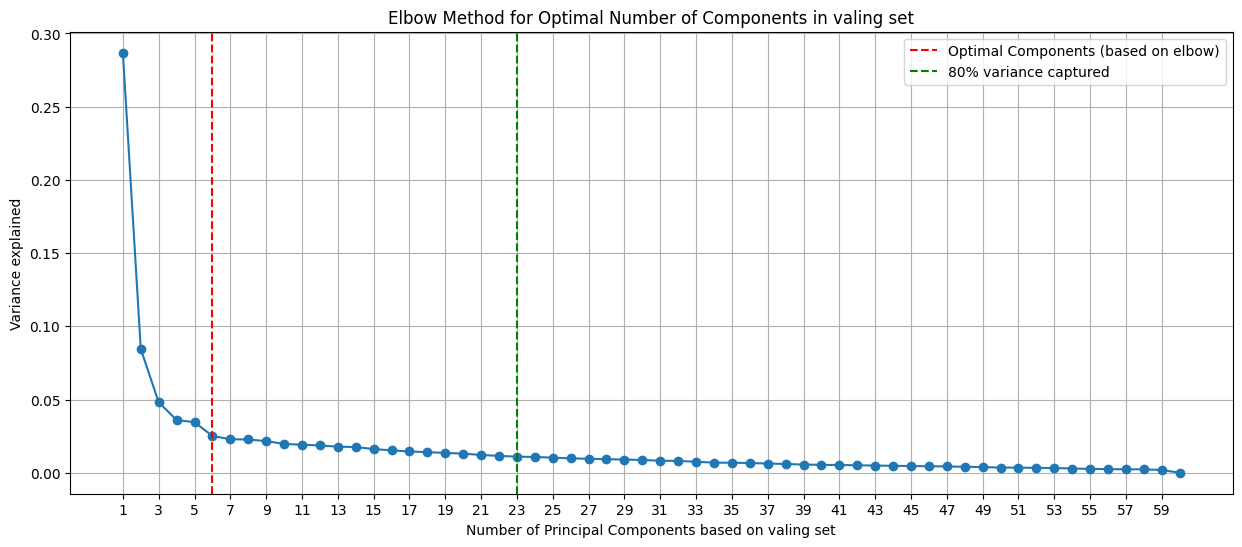

Variance captured by 23 PCs:0.80


In [49]:
pca = PCA(random_state=88, n_components=60)
pca.fit(val_data)
explained_variance = pca.explained_variance_ratio_
# Plotting the elbow curve
plt.figure(figsize=(15, 6))
plt.plot(range(1, 60 + 1), explained_variance, marker='o')
plt.xlabel('Number of Principal Components based on valing set')
plt.ylabel('Variance explained')
plt.title('Elbow Method for Optimal Number of Components in valing set')
plt.grid()
plt.xticks(range(1, 60 + 1,2))
plt.axvline(x= 6, color='r', linestyle='--', label='Optimal Components (based on elbow)')
plt.axvline(x=23, color='g', linestyle='--', label='80% variance captured')
plt.legend()
plt.show()
print(f'Variance captured by 23 PCs:{pca.explained_variance_ratio_[:23].sum():.2f}')


In [50]:
# Set up the pipeline
PCA_Pipeline = Pipeline(steps=[('pca', PCA(random_state=42)),
('classifier', LogisticRegression(max_iter=10000, penalty="none", solver='saga', tol=0.0001, random_state=42))])

# Set up a grid for each PC
pca_param_grid = {'pca__n_components': list(range(1, 24))}

# Apply
LR_pca_search_model = GridSearchCV(PCA_Pipeline, pca_param_grid, cv=KF, scoring=scoring, refit="accuracy")

# Fit
LR_pca_search_model.fit(val_data, val_labels.ravel())
# Look at best paramaters and accuracy and save results to a data frame
print(f"Best Paramater:", LR_pca_search_model.best_params_)
print(f"Best Score: {LR_pca_search_model.best_score_:.2f}")
results_pca = pd.concat([pd.DataFrame(LR_pca_search_model.cv_results_["params"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["mean_test_accuracy"], columns = ["CV Accuracy"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["std_test_accuracy"], columns=["SD accuracy"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["mean_test_precision"], columns = ["CV precision"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["std_test_precision"], columns=["SD precision"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["mean_test_recall"], columns=["CV recall"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["std_test_recall"], columns=["SD recall"])],axis=1)
results_pca.sort_values(by='CV Accuracy', inplace=True)

Best Paramater: {'pca__n_components': 6}
Best Score: 0.72


In [51]:
results_pca

,pca__n_components,CV Accuracy,SD accuracy,CV precision,SD precision,CV recall,SD recall
0,1,0.533333,0.066667,0.598095,0.198603,0.393810,0.134025
1,2,0.566667,0.081650,0.626111,0.181213,0.563810,0.187974
16,17,0.616667,0.084984,0.650397,0.131638,0.686190,0.102822
15,16,0.616667,0.066667,0.639921,0.161240,0.661190,0.099408
2,3,0.633333,0.084984,0.758333,0.171594,0.629286,0.213145
19,20,0.633333,0.084984,0.677778,0.123728,0.707619,0.177399
14,15,0.633333,0.084984,0.650635,0.176748,0.686190,0.102822
4,5,0.650000,0.033333,0.727857,0.126055,0.682857,0.183703
10,11,0.650000,0.062361,0.691667,0.158211,0.761190,0.132830
13,14,0.666667,0.105409,0.672857,0.154286,0.756190,0.078139


In [52]:
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Human_val_Logistic_regression_PCA_search.pkl', 'wb') as f:
    pickle.dump(LR_pca_search_model, f)
results_pca.to_csv(path_or_buf="/home/workspace/jogrady/ML4TB/results/Logistic_regression/CV_results/Human_val_PCA_CV_results.txt", sep = "\t")

## ICA

In [53]:
from sklearn.decomposition import FastICA
ICA_transformer = FastICA(n_components=23, # from PCA - 80% of variance
        random_state=42,
        max_iter=1000, tol=0.0001,
        whiten='unit-variance')


In [54]:
df_val_ica = ICA_transformer.fit_transform(val_data)
kurtosis_scores = [kurtosis(df_val_ica[:, i]) for i in range(df_val_ica.shape[1])]
n_components = np.argmax(kurtosis_scores) + 1
# Number of non-normal components in testing data = 14 - however we will use the same as above for PCA
n_components


4

In [55]:
ICA_Pipeline = Pipeline(steps=[('ica', FastICA( 
        random_state=42,
        max_iter=5000, tol=0.0001,
        whiten='unit-variance')),
('classifier', LogisticRegression(max_iter=10000, penalty="none", solver='saga', tol=0.0001, random_state=42))])

# Set up grid of components - 80% from PCA above
ica_param_grid = {'ica__n_components': list(range(1, 24))}


# Apply
LR_ica_search_model = GridSearchCV(ICA_Pipeline, ica_param_grid, cv=KF, scoring=scoring, refit="accuracy")


# Fit
LR_ica_search_model.fit(val_data, val_labels.ravel())
# Look at best paramaters and accuracy and save results to a data frame
print("Best Parameters:", LR_ica_search_model.best_params_)
print(f"Best Score: {LR_ica_search_model.best_score_:.2f}")
results_ica = pd.concat([pd.DataFrame(LR_ica_search_model.cv_results_["params"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["mean_test_accuracy"], columns = ["CV Accuracy"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["std_test_accuracy"], columns=["SD accuracy"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["mean_test_precision"], columns = ["CV precision"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["std_test_precision"], columns=["SD precision"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["mean_test_recall"], columns=["CV recall"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["std_test_recall"], columns=["SD recall"])],axis=1)
results_ica.sort_values(by='CV Accuracy', inplace=True)
results_ica

Best Parameters: {'ica__n_components': 3}
Best Score: 0.72


,ica__n_components,CV Accuracy,SD accuracy,CV precision,SD precision,CV recall,SD recall
0,1,0.466667,0.113039,0.556075,0.175931,0.784286,0.186285
1,2,0.500000,0.117851,0.565707,0.174806,0.804286,0.170090
16,17,0.600000,0.110554,0.631746,0.169893,0.789762,0.135014
21,22,0.616667,0.179505,0.694444,0.257001,0.664762,0.148052
20,21,0.633333,0.154560,0.711111,0.228792,0.714762,0.124270
19,20,0.633333,0.113039,0.684444,0.165343,0.764762,0.170197
18,19,0.633333,0.154560,0.711111,0.228792,0.714762,0.124270
11,12,0.650000,0.133333,0.684762,0.221199,0.814762,0.111762
22,23,0.650000,0.177951,0.720635,0.256419,0.689762,0.127205
6,7,0.666667,0.052705,0.684921,0.136950,0.786190,0.115474


In [56]:
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Human_val_Logistic_regression_ICA_search.pkl', 'wb') as f:
    pickle.dump(LR_ica_search_model, f)
results_ica.to_csv(path_or_buf="/home/workspace/jogrady/ML4TB/results/Logistic_regression/CV_results/Human_val_ICA_CV_results.txt", sep = "\t")

## NMF

In [57]:
NMF_Pipeline = Pipeline(steps=[('nmf', NMF(
    init="random", solver='cd', 
    beta_loss='frobenius', tol=0.0001, 
    max_iter=10000, random_state=42, verbose=0)),
('classifier', LogisticRegression(max_iter=10000, penalty=None, solver='saga', tol=0.0001, random_state=42))])

In [58]:
nmf_param_grid = {'nmf__n_components': list(range(1, 24))}

LR_nmf_search_model = GridSearchCV(NMF_Pipeline, nmf_param_grid, cv=KF, n_jobs= 50, scoring=scoring, refit="accuracy")

LR_nmf_search_model.fit(val_data, val_labels.ravel())
# Look at best paramaters and accuracy and save results to a data frame
print("Best Parameters:", LR_nmf_search_model.best_params_)
print(f"Best Score: {LR_nmf_search_model.best_score_:.2f}")
results_nmf = pd.concat([pd.DataFrame(LR_nmf_search_model.cv_results_["params"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["mean_test_accuracy"], columns = ["CV Accuracy"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["std_test_accuracy"], columns=["SD accuracy"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["mean_test_precision"], columns = ["CV precision"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["std_test_precision"], columns=["SD precision"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["mean_test_recall"], columns=["CV recall"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["std_test_recall"], columns=["SD recall"])],axis=1)
results_nmf.sort_values(by='CV Accuracy', inplace=True)
results_nmf

Best Parameters: {'nmf__n_components': 4}
Best Score: 0.70


,nmf__n_components,CV Accuracy,SD accuracy,CV precision,SD precision,CV recall,SD recall
1,2,0.483333,0.133333,0.559646,0.182081,0.804286,0.170090
0,1,0.500000,0.074536,0.573247,0.162103,0.812857,0.160636
21,22,0.550000,0.171594,0.613276,0.199694,0.714762,0.124270
2,3,0.566667,0.169967,0.588889,0.175260,0.844286,0.164280
19,20,0.600000,0.143372,0.653968,0.179975,0.789762,0.135014
17,18,0.616667,0.171594,0.624675,0.195504,0.779762,0.135735
12,13,0.616667,0.179505,0.651429,0.213754,0.834762,0.116190
20,21,0.633333,0.135401,0.662251,0.172303,0.809762,0.142261
18,19,0.633333,0.124722,0.660000,0.158325,0.784762,0.178820
16,17,0.633333,0.113039,0.645079,0.162199,0.809762,0.142261


In [59]:
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Human_val_Logistic_regression_NMF_search.pkl', 'wb') as f:
    pickle.dump(LR_nmf_search_model, f)

#

# Pairwise Comparison

In [60]:
8# Load in the models
with open("/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Human_train_gene_LR_l10.7_search.pkl", 'rb') as f:
    train_gene = pickle.load(f)

with open("/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Human_test_gene_LR_l10.9_search.pkl", 'rb') as f:
    Test_gene = pickle.load(f)
with open("/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Human_val_gene_LR_l10.9_search.pkl", 'rb') as f:
    Val_gene = pickle.load(f)

# PCA
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Human_train_Logistic_regression_PCA_search.pkl', 'rb') as f:
    Train_PCA = pickle.load(f)
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Human_test_Logistic_regression_PCA_search.pkl', 'rb') as f:
    Test_PCA = pickle.load(f)
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Human_val_Logistic_regression_PCA_search.pkl', 'rb') as f:
    Val_PCA = pickle.load(f)
    
    
# ICA
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Human_train_Logistic_regression_ICA_search.pkl', 'rb') as f:
    Train_ICA = pickle.load(f)
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Human_test_Logistic_regression_ICA_search.pkl', 'rb') as f:
    Test_ICA = pickle.load(f)
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Human_val_Logistic_regression_ICA_search.pkl', 'rb') as f:
    Val_ICA = pickle.load(f)
    
# NMF
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Human_train_Logistic_regression_NMF_search.pkl', 'rb') as f:
    Train_NMF = pickle.load(f)
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Human_test_Logistic_regression_NMF_search.pkl', 'rb') as f:
    Test_NMF = pickle.load(f)
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression/Human_val_Logistic_regression_NMF_search.pkl', 'rb') as f:
    Val_NMF = pickle.load(f)

## Training performance on the test and val data

In [88]:
test_data_train_normalised = test_data_train_normalised.filter(items = genes_train, axis=1)
val_data_train_normalised = val_data_train_normalised.filter(items = genes_train, axis=1)

### Gene based classifier

In [100]:
y_score_gene = train_gene.predict_proba(test_data_train_normalised)
test_train_fprG_gene, test_train_tprG_gene, test_train_t_gene = roc_curve(test_labels.ravel(), y_score_gene[:,1])
test_train_roc_aucG_gene = auc(test_train_fprG_gene, test_train_tprG_gene)
print(test_train_roc_aucG_gene)

y_score_gene = train_gene.predict_proba(val_data_train_normalised)
val_train_fprG_gene, val_train_tprG_gene, val_train_t_gene = roc_curve(val_labels.ravel(), y_score_gene[:,1])
val_train_roc_aucG_gene = auc(val_train_fprG_gene, val_train_tprG_gene)
print(val_train_roc_aucG_gene)


# PCA
y_score_pca = Train_PCA.predict_proba(test_data_train_normalised)
test_train_fprG_pca, test_train_tprG_pca, test_train_t_pca = roc_curve(test_labels.ravel(), y_score_pca[:,1])
test_train_roc_aucG_pca = auc(test_train_fprG_pca, test_train_tprG_pca)
print(test_train_roc_aucG_pca)

y_score_pca = Train_PCA.predict_proba(val_data_train_normalised)
val_train_fprG_pca, val_train_tprG_pca, val_train_t_pca = roc_curve(val_labels.ravel(), y_score_pca[:,1])
val_train_roc_aucG_pca = auc(val_train_fprG_pca, val_train_tprG_pca)
print(val_train_roc_aucG_pca)

# ICA
y_score_ica = Train_ICA.predict_proba(test_data_train_normalised)
test_train_fprG_ica, test_train_tprG_ica, test_train_t_ica = roc_curve(test_labels.ravel(), y_score_ica[:,1])
test_train_roc_aucG_ica = auc(test_train_fprG_ica, test_train_tprG_ica)
print(test_train_roc_aucG_ica)

y_score_ica = Train_ICA.predict_proba(val_data_train_normalised)
val_train_fprG_ica, val_train_tprG_ica, val_train_t_ica = roc_curve(val_labels.ravel(), y_score_ica[:,1])
val_train_roc_aucG_ica = auc(val_train_fprG_ica, val_train_tprG_ica)
print(val_train_roc_aucG_ica)

# NMF
y_score_nmf = Train_NMF.predict_proba(test_data_train_normalised)
test_train_fprG_nmf, test_train_tprG_nmf, test_train_t_nmf = roc_curve(test_labels.ravel(), y_score_nmf[:,1])
test_train_roc_aucG_nmf = auc(test_train_fprG_nmf, test_train_tprG_nmf)
print(test_train_roc_aucG_nmf)

y_score_nmf = Train_NMF.predict_proba(val_data_train_normalised)
val_train_fprG_nmf, val_train_tprG_nmf, val_train_t_nmf = roc_curve(val_labels.ravel(), y_score_nmf[:,1])
val_train_roc_aucG_nmf = auc(val_train_fprG_nmf, val_train_tprG_nmf)
print(val_train_roc_aucG_nmf)



0.8954248366013072
0.8788571428571428
0.8888888888888887
0.7622857142857143
0.8714596949891068
0.7771428571428571
0.7701525054466231
0.7805714285714286


## Test performance on training and validation

In [114]:
train_data_test_normalised = train_data_test_normalised.filter(items = genes_test, axis=1)
val_data_test_normalised = val_data_test_normalised.filter(items = genes_test, axis=1)

In [118]:
y_score_gene = Test_gene.predict_proba(train_data_test_normalised)
train_test_fprG_gene, train_test_tprG_gene, train_test_t_gene = roc_curve(train_labels.ravel(), y_score_gene[:,1])
train_test_roc_aucG_gene = auc(train_test_fprG_gene, train_test_tprG_gene)
print(train_test_roc_aucG_gene)

y_score_gene = Test_gene.predict_proba(val_data_test_normalised)
val_test_fprG_gene, val_test_tprG_gene, val_test_t_gene = roc_curve(val_labels.ravel(), y_score_gene[:,1])
val_test_roc_aucG_gene = auc(val_test_fprG_gene, val_test_tprG_gene)
print(val_test_roc_aucG_gene)


# PCA
y_score_pca = Test_PCA.predict_proba(train_data_test_normalised)
train_test_fprG_pca, train_test_tprG_pca, train_test_t_pca = roc_curve(train_labels.ravel(), y_score_pca[:,1])
train_test_roc_aucG_pca = auc(train_test_fprG_pca, train_test_tprG_pca)
print(train_test_roc_aucG_pca)

y_score_pca = Test_PCA.predict_proba(val_data_test_normalised)
val_test_fprG_pca, val_test_tprG_pca, val_test_t_pca = roc_curve(val_labels.ravel(), y_score_pca[:,1])
val_test_roc_aucG_pca = auc(val_test_fprG_pca, val_test_tprG_pca)
print(val_test_roc_aucG_pca)

# ica
y_score_ica = Test_ICA.predict_proba(train_data_test_normalised)
train_test_fprG_ica, train_test_tprG_ica, train_test_t_ica = roc_curve(train_labels.ravel(), y_score_ica[:,1])
train_test_roc_aucG_ica = auc(train_test_fprG_ica, train_test_tprG_ica)
print(train_test_roc_aucG_ica)

y_score_ica = Test_ICA.predict_proba(val_data_test_normalised)
val_test_fprG_ica, val_test_tprG_ica, val_test_t_ica = roc_curve(val_labels.ravel(), y_score_ica[:,1])
val_test_roc_aucG_ica = auc(val_test_fprG_ica, val_test_tprG_ica)
print(val_test_roc_aucG_ica)

# nmf
y_score_nmf = Test_NMF.predict_proba(train_data_test_normalised)
train_test_fprG_nmf, train_test_tprG_nmf, train_test_t_nmf = roc_curve(train_labels.ravel(), y_score_nmf[:,1])
train_test_roc_aucG_nmf = auc(train_test_fprG_nmf, train_test_tprG_nmf)
print(train_test_roc_aucG_nmf)

y_score_nmf = Test_NMF.predict_proba(val_data_test_normalised)
val_test_fprG_nmf, val_test_tprG_nmf, val_test_t_nmf = roc_curve(val_labels.ravel(), y_score_nmf[:,1])
val_test_roc_aucG_nmf = auc(val_test_fprG_nmf, val_test_tprG_nmf)
print(val_test_roc_aucG_nmf)

0.874789714011055
0.864
0.8401826484018265
0.7794285714285714
0.8372987262677242
0.7897142857142857
0.8644556596971882
0.7348571428571429


## Val performance on training and validation

In [119]:
train_data_val_normalised = train_data_val_normalised.filter(items = genes_val, axis=1)
test_data_val_normalised = test_data_val_normalised.filter(items = genes_val, axis=1)

In [122]:
y_score_gene = Val_gene.predict_proba(train_data_val_normalised)
train_val_fprG_gene, train_val_tprG_gene, train_val_t_gene = roc_curve(train_labels.ravel(), y_score_gene[:,1])
train_val_roc_aucG_gene = auc(train_val_fprG_gene, train_val_tprG_gene)
print(train_val_roc_aucG_gene)

y_score_gene = Val_gene.predict_proba(test_data_val_normalised)
test_val_fprG_gene, test_val_tprG_gene, test_val_t_gene = roc_curve(test_labels.ravel(), y_score_gene[:,1])
test_val_roc_aucG_gene = auc(test_val_fprG_gene, test_val_tprG_gene)
print(test_val_roc_aucG_gene)


y_score_pca = Val_PCA.predict_proba(train_data_val_normalised)
train_val_fprG_pca, train_val_tprG_pca, train_val_t_pca = roc_curve(train_labels.ravel(), y_score_pca[:,1])
train_val_roc_aucG_pca = auc(train_val_fprG_pca, train_val_tprG_pca)
print(train_val_roc_aucG_pca)

y_score_pca = Val_PCA.predict_proba(test_data_val_normalised)
test_val_fprG_pca, test_val_tprG_pca, test_val_t_pca = roc_curve(test_labels.ravel(), y_score_pca[:,1])
test_val_roc_aucG_pca = auc(test_val_fprG_pca, test_val_tprG_pca)
print(test_val_roc_aucG_pca)


y_score_ica = Val_ICA.predict_proba(train_data_val_normalised)
train_val_fprG_ica, train_val_tprG_ica, train_val_t_ica = roc_curve(train_labels.ravel(), y_score_ica[:,1])
train_val_roc_aucG_ica = auc(train_val_fprG_ica, train_val_tprG_ica)
print(train_val_roc_aucG_ica)

y_score_ica = Val_ICA.predict_proba(test_data_val_normalised)
test_val_fprG_ica, test_val_tprG_ica, test_val_t_ica = roc_curve(test_labels.ravel(), y_score_ica[:,1])
test_val_roc_aucG_ica = auc(test_val_fprG_ica, test_val_tprG_ica)
print(test_val_roc_aucG_ica)


y_score_nmf = Val_NMF.predict_proba(train_data_val_normalised)
train_val_fprG_nmf, train_val_tprG_nmf, train_val_t_nmf = roc_curve(train_labels.ravel(), y_score_nmf[:,1])
train_val_roc_aucG_nmf = auc(train_val_fprG_nmf, train_val_tprG_nmf)
print(train_val_roc_aucG_nmf)

y_score_nmf = Val_NMF.predict_proba(test_data_val_normalised)
test_val_fprG_nmf, test_val_tprG_nmf, test_val_t_nmf = roc_curve(test_labels.ravel(), y_score_nmf[:,1])
test_val_roc_aucG_nmf = auc(test_val_fprG_nmf, test_val_tprG_nmf)
print(test_val_roc_aucG_nmf)

0.817832251862533
0.8583877995642701
0.7495794280221101
0.6949891067538126
0.7325162220620043
0.6938997821350763
0.7411679884643114
0.7047930283224401
